# Transit Method
Of of the most successful methods to date for exoplanet discovery is the Transit Method. Basically, we are looking for when exoplanets eclipse (or transit) across the face of their stars. Here is a great overview of the method:
[https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/](https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/)

![Image of Transit Method](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-30648-3_117-1/MediaObjects/395338_0_En_117-1_Fig2_HTML.png)

## To exploit the shape of a transit (u-ish, v-ish shaped). There are currently two main period detection algorithms in use:

## 1) Box-fitting Least Squares (BLS)

## 2) Transit Least Squares (TLS)

Before we begin, lets take our fake light curve (See Intro to Python tutorial) and inject simulated planets into it.

In [197]:
# These are all the modules and definitions you will need in this notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec
import time
import batman
from astropy.stats import BoxLeastSquares
from transitleastsquares import period_grid

#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying.

from transitleastsquares import transitleastsquares
from transitleastsquares import catalog_info
from transitleastsquares import transit_mask


# These are used to employ your computers operating system (os) to
# search through your directories for specific files.
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
from scipy.signal import savgol_filter


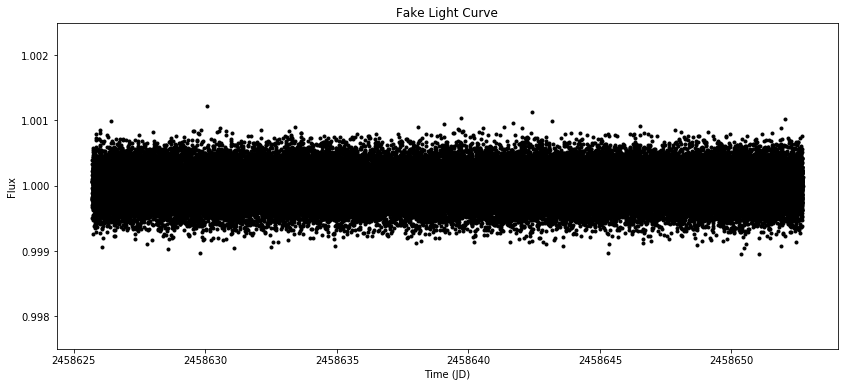

In [198]:

fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 2*60 #take measurement twice an hour
pts_per_day = 24*cadence #data points per day
scatter_frac = 0.00025  # add scatter to data to make it realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day
t = 2458625.7 + np.linspace(start, stop, stepsize) 

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

To inject fake planets into our data, we will be using the BATMAN Python module (included in the transitleastsquares installation). This module utilizes a Mandel-Agol transit model to fit transit events.

Read more about BATMAN here: [https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html](https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html)

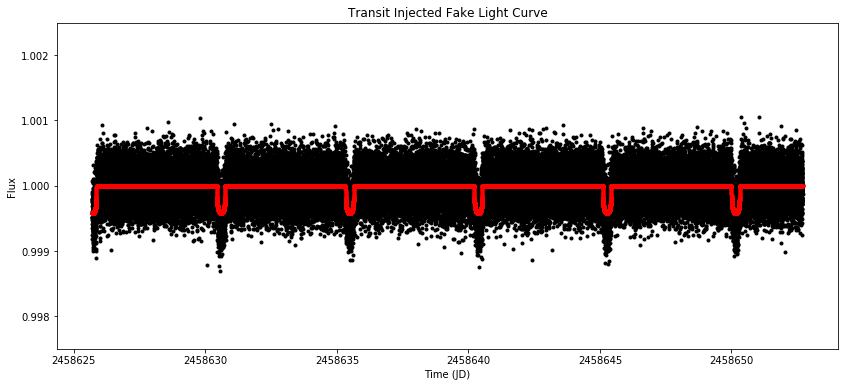

In [199]:
Rad_sun = 6.955*10.0**10.0 #cm
Rad_earth = 6.378*10.0**8.0 #cm
Mass_Sun = 1.989*10.0**33.0 #grams

time_start = t[0] #[0] =first data point in array

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = 4.8910  # orbital period
ma.rp = 2.0*Rad_earth/Rad_sun  # planet radius (in units of stellar radii) 
ma.a = 5  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

injectedflux = synthetic_signal- flux+1

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,injectedflux,marker='.',color='black',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

## First lets try applying BLS.

BLS works by searching a grid of different trial orbital periods and transit durations to see what shaped box best fits the data

In [200]:
# First lets make the grid
LCduration = t[-1]-t[0] #duration of light curve (last minus first data point)

# lets pick min/max of orbital period grid
minP=0.25;maxP = LCduration #orbital periods for grid

# lets pick min/max of transit duration grid
minT = 1.0/24.0; maxT = 5.0/24.0 # transit durations hours

#Lets make up values for our star
R_star = 0.15 # Solar radii
M_star = 0.12 # Solar masses

durations = np.linspace(minT, maxT, 25) #toy around with stepsize for run time optimization

periods = period_grid(R_star=R_star, M_star=M_star, time_span=LCduration, period_min=minP, period_max=maxP)#,oversampling_factor=10)



#start BLS search
bls = BoxLeastSquares(t, injectedflux) #just for specific target
bls_power = bls.power(periods, durations)
    
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

index = np.argmax(bls_power.power) #finds strongest peak in BLS power spectrum
BLS_periods=bls_power.period[index]
BLS_t0s=bls_power.transit_time[index]
BLS_depths=bls_power.depth[index]
dur = minT #0.5

bls_model=bls.model(t,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

# plt.figure(figsize=(15, 10))
# plt.plot(np.log10(bls_power.period), bls_SDE, "k")
# plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
# plt.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
#                         xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
# plt.ylabel("SDE",fontsize=fs)
# plt.xlim(np.log10(periods.min())-0.1, np.log10(periods.max())+0.1)
# # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
# plt.xlabel("log(Period ( days))",fontsize=fs)
# plt.show()

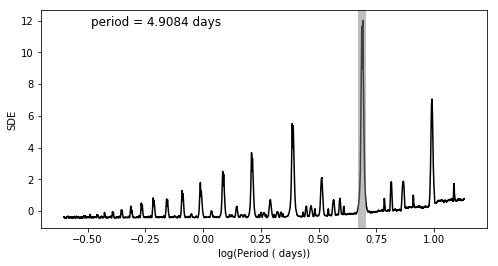

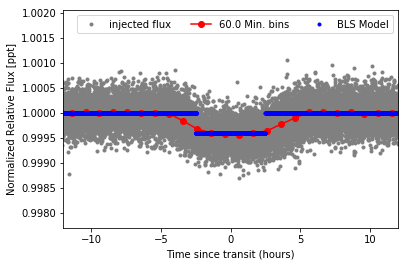

In [201]:
fs=10
plt.figure(figsize=(8, 4))
plt.plot(np.log10(bls_power.period), bls_SDE, "k")
plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
plt.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
                        xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
plt.ylabel("SDE",fontsize=fs)
plt.xlim(np.log10(periods.min())-0.1, np.log10(periods.max())+0.1)
# plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
plt.xlabel("log(Period ( days))",fontsize=fs)
plt.show()

# Plot the folded transit
p = BLS_periods
x_fold = (t - BLS_t0s + 0.5*p) % p - 0.5*p

 
binsize= 60.0/(60.0*24.0) 
bint,binf,binfe = Bin_func(x_fold, injectedflux,fluxerr,binsize)

plt.plot(24.0*x_fold, injectedflux, color='grey',marker=".",linestyle='none',label='injected flux')
plt. plot(24.0*bint, binf, color="r",marker='o',label=str(binsize*24*60)+' Min. bins') #hours
plt.plot(24.0*x_fold, bls_model, ".b",label='BLS Model') #hours

plt.xlim(-0.5*24.0, 0.5*24.0)
plt.ylim(np.min(injectedflux)-0.001, np.max(injectedflux)+0.001)  #just for specific target      
plt.ylabel("Normalized Relative Flux [ppt]",fontsize=fs)
plt.xlabel("Time since transit (hours)",fontsize=fs)
plt.legend(loc='upper right',ncol=3)
plt.show()

In [202]:
print("1")
print(1,"2",start)
print("hi"+" world",1," 2")


1
1 2 0.0
hi world 1  2


In [203]:
## Now lets try with TLS

In [204]:




start = time.time()
# first we need limb-darkening coefficients
qld=[0.4,0.4]

#start TLS with same BLS inputs
model = transitleastsquares(t, injectedflux)
results = model.power(period_max=maxP,show_progress_bar=False)#,duration_grid_step=2)

#TLS results
TLS_periods=results.period
TLS_t0s=results.T0
TLS_depths=results.depth
TLS_SDE=results.power
    
#TLS results
phase_model = results.model_folded_phase
TLS_model = results.model_folded_model
phase = results.folded_phase
folded_y = results.folded_y


end = time.time()

runtime = end-start #seconds

print(" ")
print(" ") #adding some spac ebtween print statements
print(" ")

print("runtime: ", runtime, "seconds")

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 28 durations
Searching 77760 data points, 2459 periods from 0.601 to 13.5 days
Using all 4 CPU threads
 
runtime:  224.78254222869873 seconds


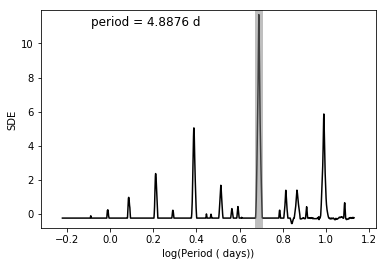

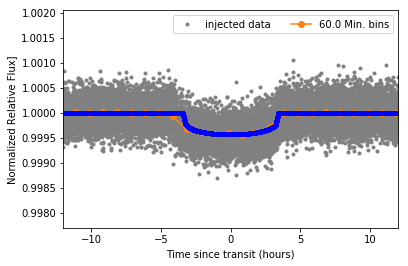

In [205]:
plt.plot(np.log10(results.periods), TLS_SDE, "k")
plt.axvline(np.log10(ma.per), color="grey", lw=8, alpha=0.5) #this is our injected transit period
plt.annotate("period = {0:.4f} d".format(results.period),(0, 1), xycoords="axes fraction",
                    xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
plt.ylabel("SDE",fontsize=fs)
plt.xlim(np.log10(results.periods.min())-0.1, np.log10(results.periods.max())+0.1)
plt.ylim(TLS_SDE.min()-0.25, TLS_SDE.max()+0.25)
plt.xlabel("log(Period ( days))",fontsize=fs)
plt.show()

p = TLS_periods
x_fold = (t - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = (results.model_lightcurve_time - TLS_t0s + 0.5*p) % p - 0.5*p

plt.plot(24.0*x_fold, injectedflux, color='grey',marker=".",linestyle='none',label='injected data')
bint,binf,binfe = Bin_func(x_fold, injectedflux,fluxerr,binsize) #just for specific target
plt.plot(24.0*bint, binf, color="C1",marker='o',label=str(binsize*24*60)+' Min. bins') #hours
plt.plot(24.0*pf_model,results.model_lightcurve_model, "b.") #hours

plt.ylim(np.min(injectedflux)-0.001, np.max(injectedflux)+0.001)  #just for specific target      
plt.ylabel("Normalized Relative Flux]",fontsize=fs)
plt.xlabel("Time since transit (hours)",fontsize=fs)
plt.legend(loc='upper right',ncol=3)
plt.xlim(-0.5*24.0, 0.5*24.0)
plt.show()

In [206]:
# %reset 

# Now, let's trying doing this with real data from TESS.

## Here, we will start to combine our first 4 notebooks into one large "pipeline" to check as many light curves as we like.

The outline of our pipeline is like such:
* load in our filtergraph light curves
* make sure there are known stellar masses, radii and quadratic limb-darkening parameters for our target stars
* clean up these light curves with smoothing and outlier removal
* conduct a BLS search and record results
* with BLS results, fold data over the best orbital period of the strongest peaks
* To ensure our BLS results are significant, we should probably imploy a quality check:

    if BLS Signal Detection Efficiency is lower then a threshold (I arbitrarily chose 6.5), then move onto the next light curve


* plot all three figures together

In [207]:
#Now we're going to define a variable with the path name of where our light curves are located

#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  24


In [208]:
cad = 0.020752000000129556 # typical seperation in time, between data points (in units of days). Should be same for all data sets.
print(cad)

print("cadence: ")
print(cad," days; in hours: ",cad*24.0)

#now let's define a window size to smooth our data with:
print(" ")
window_size = int(5.0/cad) #number of data points in 5 hours
if (window_size % 2) == 0: #must be odd. If not, there will be an error
    window_size = window_size+1
print("number of data points in ",5," hours: ",window_size)

0.020752000000129556
cadence: 
0.020752000000129556  days; in hours:  0.49804800000310934
 
number of data points in  5  hours:  241


In [209]:
# Below is a custom function to remove outliers in our light curves.
# This is a less aggresive approach than a 3*standard deviation
# cut that is commonly used in astronomy.

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

TIC ID:  126910743
Quadratic limb darkening q1, q2:  0.1604 0.4325
Stellar radius:  0.334511 + 0.0202403 - 0.0202403 solar radii
Stellar mass:  0.350263 + 0.0104742 - 0.0104742 solar mass
 


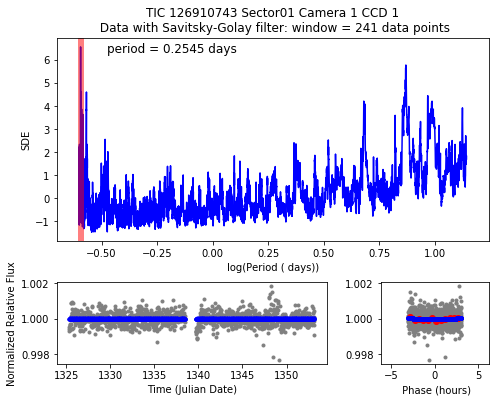

 
TIC ID:  129637152
Quadratic limb darkening q1, q2:  0.2946 0.3316
Stellar radius:  0.574222 + 0.0202568 - 0.0202568 solar radii
Stellar mass:  0.583273 + 0.0172833 - 0.0172833 solar mass
 


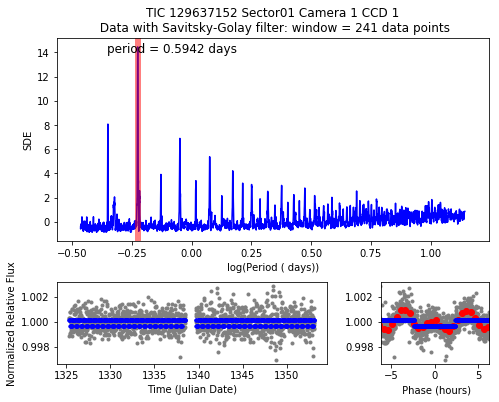

 
TIC ID:  129683871
Quadratic limb darkening q1, q2:  0.2946 0.3316
Stellar radius:  0.61 + 0.0769401 - 0.0769401 solar radii
Stellar mass:  0.933881 + 0.101568 - 0.101568 solar mass
 


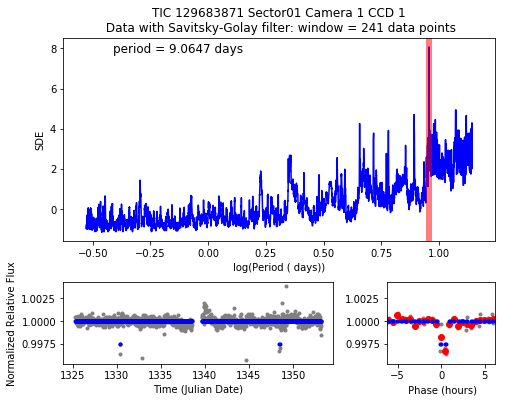

 
TIC ID:  197598732
Quadratic limb darkening q1, q2:  0.1529 0.4604
Stellar radius:  0.306625 + 0.0206174 - 0.0206174 solar radii
Stellar mass:  0.326131 + 0.0103763 - 0.0103763 solar mass
 


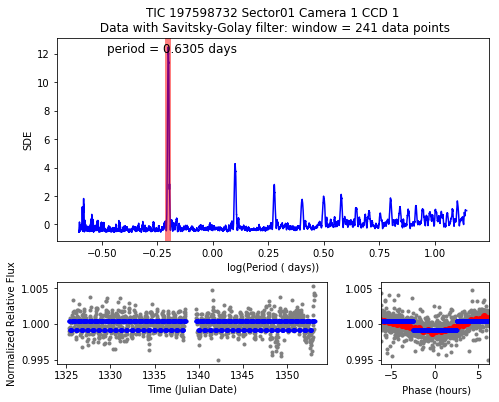

 
TIC ID:  200644837
Quadratic limb darkening q1, q2:  0.1529 0.4604
Stellar radius:  0.354317 + 0.020233 - 0.020233 solar radii
Stellar mass:  0.367433 + 0.010947 - 0.010947 solar mass
 


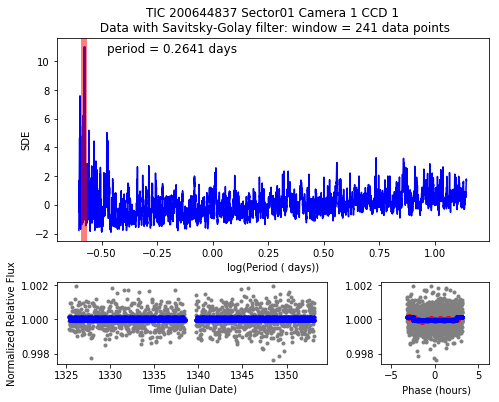

 
TIC ID:  382220859
Quadratic limb darkening q1, q2:  0.2581 0.3609
Stellar radius:  0.553409 + 0.0202745 - 0.0202745 solar radii
Stellar mass:  0.559147 + 0.0165918 - 0.0165918 solar mass
 


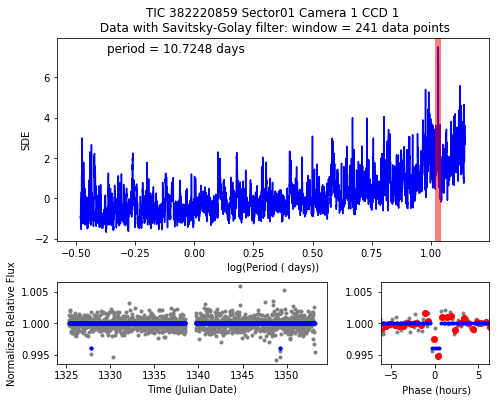

 
TIC ID:  389448805
Quadratic limb darkening q1, q2:  0.1604 0.4325
Stellar radius:  0.400992 + 0.0203401 - 0.0203401 solar radii
Stellar mass:  0.408455 + 0.0122581 - 0.0122581 solar mass
 


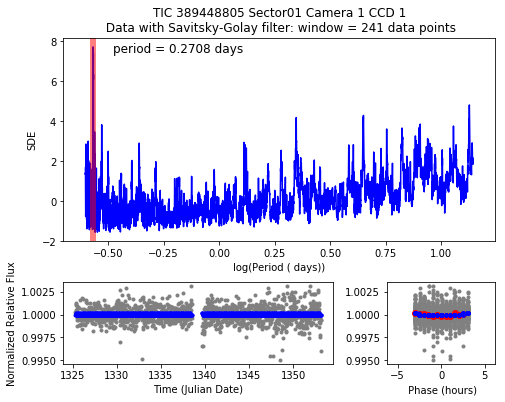

 
TIC ID:  389657088
Quadratic limb darkening q1, q2:  0.1671 0.4201
Stellar radius:  0.375802 + 0.0202719 - 0.0202719 solar radii
Stellar mass:  0.386183 + 0.011532 - 0.011532 solar mass
 


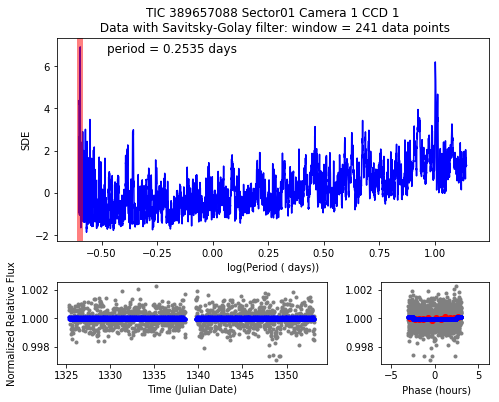

 
done


In [217]:
quality_threshold = 6.5 #cut off for SDE


for ii in range(len(data)): #for full data set

    d = np.loadtxt(data[ii])  #load in data

    t = np.transpose(d)[0] #time
    mm = np.transpose(d)[1] #magnitude
    mme = np.transpose(d)[2] #magnitude error

    #  to convert from magnitude to flux, you can use the following approximation:
    y = 10.0**(mm/-2.5) #flux
    # let's normalize our flux by dividing by its average
    y = 10.0**(mm/-2.5)/np.mean(10.0**(mm/-2.5)) #now it should be centered on 1

    # to convert magnitude errors to flux errors, you can use the following approximation:
    z = y*( 1- 10.0**(mme/-2.5) )


    ID = (os.path.basename(data[ii]).split)('_')[0]
    

    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]

    o = np.ones(len(y), dtype=bool)

    # lets smooth for a total of 10 times. Experiment with more or less iterations:
    for i in range(10):  #Note: You can place a for-loop inside a for-loop!
        y_prime = np.interp(t, t[o], y[o])
        smooth = savgol_filter(y_prime, window_size, polyorder=3)
        resid = y - smooth
        sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
        o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
        if o.sum() == o0.sum():
            o = o0
            break
        o = o0

    # Only discard positive outliers
    o = resid < 3.0*sigma

    #removing outliers with Chauvenet's criterion after smoothing
    t2,f2,fe2 = ChauventsCriteron(t,resid+1,z)

    LCduration = t2[-1]-t2[0] #duration of light curve (last minus first data point)
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))
    #^^^ grabbing stellar information from MAST catalogs
    
    # lets pick min/max of orbital period grid
    minP=0.25
    maxP = LCduration #orbital periods for grid
    
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=LCduration, period_min=minP, period_max=maxP)#,oversampling_factor=10)
    
    #start BLS search
    bls = BoxLeastSquares(t2, f2) #just for specific target
    bls_power = bls.power(periods, durations)

    bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
    
    #here we will make a quality check. If max SDE < 8, we will move onto the next light curve
    if np.max(bls_SDE) < quality_threshold:
        continue #continue tells Python to move onto the next file in the list
    else: #if bls_SDE > quality control, do the following below:
        
        if R_star == np.nan or M_star == np.nan: #checks to see if stellar information is unknown in MAST catalogs
            continue
        else: 
            print("TIC ID: ",ID) 
            print('Quadratic limb darkening q1, q2: ', qld[0], qld[1])
            print('Stellar radius: ', R_star, '+', R_star_max, '-', R_star_min, 'solar radii')
            print('Stellar mass: ', M_star, '+', M_star_max, '-', M_star_min,'solar mass')
            print(" ")



            index = np.argmax(bls_power.power) #finds the index corresponding to the strongest peak in BLS power spectrum
            BLS_periods=bls_power.period[index]
            BLS_t0s=bls_power.transit_time[index]
            BLS_depths=bls_power.depth[index]
            dur = minT #0.5

            #creating the best fit box model to our data
            bls_model=bls.model(t2,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

            #creating figure with three plots: 
            # 1) BLS power spectrum aka periodogram (top,ax1) 
            # 2) light curve (lower left, ax2) 
            # 3) phase folded light curve (lower right, ax3)

            fig = plt.figure(figsize=(10,6))
            gs1 = gridspec.GridSpec(3, 3)
            gs1.update(left=0.65, right=1.25, wspace=0.5,hspace=0.5)

            ax1 = fig.add_subplot(gs1[:-1, :])
            ax2 = fig.add_subplot(gs1[-1, :-1])
            ax3 = fig.add_subplot(gs1[-1, -1])

            ax1.plot(np.log10(bls_power.period), bls_SDE, "b")
            ax1.axvline(np.log10(BLS_periods), color="red", lw=6, alpha=0.5) #this is our strongest peak
            ax1.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
                                    xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
            ax1.set_ylabel("SDE",fontsize=fs)
            ax1.set_xlim(np.log10(periods.min())-0.1, np.log10(periods.max())+0.1)
            # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
            ax1.set_xlabel("log(Period ( days))",fontsize=fs)
            ax1.set_title(("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window_size)+" data points"))


            ax2.plot(t2, f2,color='grey',marker=".",linestyle='none')
            ax2.plot(t2,bls_model,'b.')
            ax2.set_xlabel("Time (Julian Date)")
            ax2.set_ylabel("Normalized Relative Flux")

            # Plot the folded transit
            p = BLS_periods
            x_fold = (t2 - BLS_t0s + 0.5*p) % p - 0.5*p

            #Bin the data
            binsize= 30.0/(60.0*24.0) 
            bint,binf,binfe = Bin_func(x_fold, f2,fe2,binsize)

            ax3.plot(24*x_fold,f2,color='grey',marker=".",linestyle='none')#,label='smoothed subtracted data')
            ax3.plot(24*bint,binf,'ro')#,label='binned data, 30 min bins'
            ax3.plot(24*x_fold,bls_model,'b.')#,label='BLS model'
            ax3.set_xlabel(" Phase (hours)")
    #         ax3.legend(loc='best')
            ax3.set_xlim(-0.25*24-0.2,0.25*24+0.2) #+/- 0.2 hours
            fig.tight_layout()
            plt.show()

    print(" ")

    
print("done")    